# Running the particle filter without running the particle filter

In [2]:
from epymorph.adrio import acs5
from epymorph import *  # noqa: F403
from epymorph.geography.us_census import StateScope
from epymorph.data.ipm.sirh import SIRH
from epymorph.data.mm.no import No
from epymorph.initializer import Proportional
from epymorph.rume import SingleStrataRUME
from epymorph.time import TimeFrame
import numpy as np

duration = 7 * 53 + 1
t = np.arange(0, duration)
true_beta = 0.03 * np.cos(t * 2 * np.pi / (365)) + 0.28

rume = SingleStrataRUME.build(
    ipm=SIRH(),
    mm=No(),
    scope=StateScope.in_states(["AZ"], year=2015),
    init=Proportional(ratios=np.array([9999, 1, 0, 0], dtype=np.int64)),
    time_frame=TimeFrame.of("2022-10-01", duration),
    params={
        "beta": true_beta,
        "gamma": 0.25,
        "xi": 1 / 365,  # 0.0111,
        "hospitalization_prob": 0.01,
        "hospitalization_duration": 5.0,
        "population": acs5.Population(),
    },
)

In [3]:
rume.time_frame.start_date

datetime.date(2022, 10, 1)

In [4]:
from epymorph.parameter_fitting.utils.observations import ModelLink

from epymorph.time import EveryNDays

quantity_selection = rume.ipm.select.events("I->H")
time_selection = rume.time_frame.select.all().group(EveryNDays(7)).agg()
geo_selection = rume.scope.select.all()


model_link = ModelLink(
    quantity=quantity_selection,
    time=time_selection,
    geo=geo_selection,
)

In [5]:
from epymorph.parameter_fitting.utils.parameter_estimation import EstimateParameters
from epymorph.parameter_forecasting.forecast_class import ForecastSimulation
from epymorph.parameter_fitting.distribution import Uniform
from epymorph.parameter_fitting.dynamics import GeometricBrownianMotion

params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=Uniform(a=0.05, b=0.5),
        dynamics=GeometricBrownianMotion(volatility=0.04),
    )
}


sim = ForecastSimulation(
    num_particles=100,
    rume=rume,
    params_space=params_space,
    model_link=model_link,
    duration=53,
)

In [6]:
import time

start_time = time.time()
forecast_output_2 = sim.run()
end_time = time.time()
time_taken = end_time - start_time

print(f"Time taken to run the forecast simulation: {time_taken} seconds")


start: 2022-10-08---particles: [[6641264     664       0       0]]
start: 2022-10-15---particles: [[6639972     781    1171       4]]
start: 2022-10-22---particles: [[6637119    1714    3083      12]]
start: 2022-10-29---particles: [[6630754    3726    7415      33]]
start: 2022-11-05---particles: [[6615154    9331   17372      71]]
start: 2022-11-12---particles: [[6574593   24586   42582     167]]
start: 2022-11-19---particles: [[6484901   53761  102884     382]]
start: 2022-11-26---particles: [[6265803  132309  242862     954]]
start: 2022-12-03---particles: [[5723196  324959  591403    2370]]
start: 2022-12-10---particles: [[4906955  470729 1259776    4468]]
start: 2022-12-17---particles: [[3991549  525191 2119074    6114]]
start: 2022-12-24---particles: [[3373391  374877 2887950    5710]]
start: 2022-12-31---particles: [[2987463  254007 3396221    4237]]
start: 2023-01-07---particles: [[2770838  164861 3703265    2964]]
start: 2023-01-14---particles: [[2670088  101286 3868635    19

In [7]:
# forecast_output_2 = sim.run()

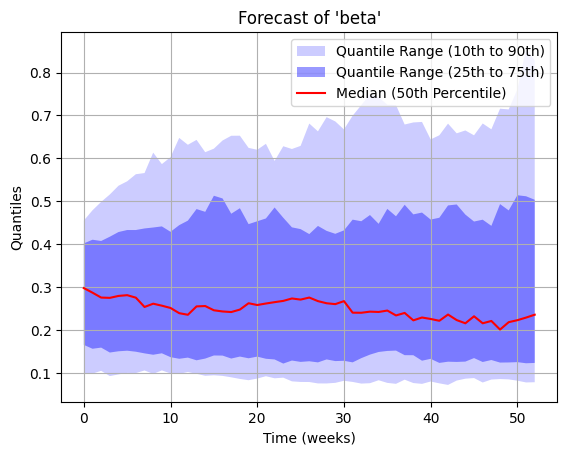

In [8]:
import matplotlib.pyplot as plt


key = "beta"
node_index = 0
truth = None

key_quantiles = np.array(forecast_output_2.param_quantiles[key])

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 3, 0],
    key_quantiles[:, 22 - 3, 0],
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th)",
)

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 6, 0],
    key_quantiles[:, 22 - 6, 0],
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th)",
)

plt.plot(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 11, 0],
    color="red",
    label="Median (50th Percentile)",
)


plt.title(f"Forecast of '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

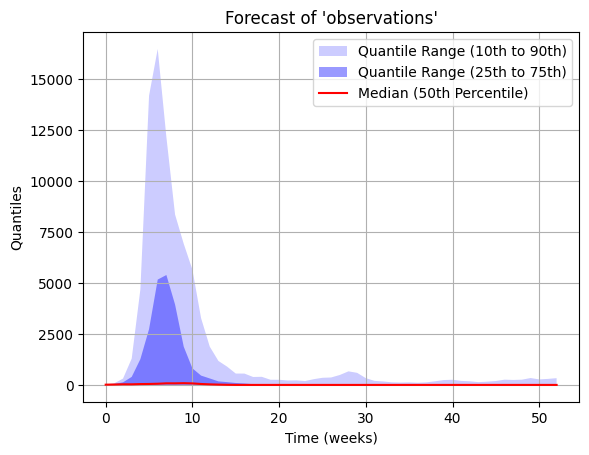

In [9]:
import matplotlib.pyplot as plt


key = "observations"
node_index = 0
truth = None

key_quantiles = np.array(forecast_output_2.model_data_quantiles)

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 3, 0],
    key_quantiles[:, 22 - 3, 0],
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th)",
)
plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 6, 0],
    key_quantiles[:, 22 - 6, 0],
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th)",
)

plt.plot(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 11, 0],
    color="red",
    label="Median (50th Percentile)",
)

plt.title(f"Forecast of '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

In [10]:
forecast_output_2.model_data.squeeze()

array([  14,   31,   98,  430, 1682, 3514, 4198, 3309, 2626, 2047, 1435,
        944,  592,  429,  446,  295,  158,  118,  117,  139,  189,  262,
        312,  294,  267,  244,  228,  206,  197,  201,  208,  214,  183,
        149,  160,  249,  287,  198,  125,  117,  155,  202,  220,  188,
        144,  118,   98,   99,  136,  265,  307,  260,  322])

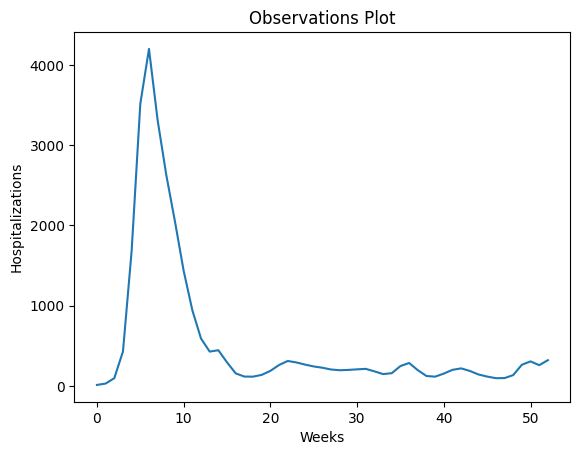

In [11]:
plt.plot(forecast_output_2.model_data)
plt.title("Observations Plot")
plt.xlabel("Weeks")
plt.ylabel("Hospitalizations")
plt.show()

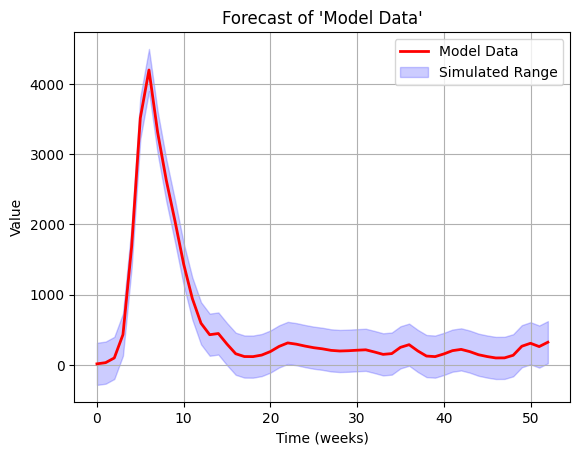

In [12]:
model_data = forecast_output_2.model_data

# Generate a range for the x-axis based on the length of model_data
x_values = np.arange(0, len(model_data))

# Plotting the model data
plt.plot(x_values, model_data, color="red", label="Model Data", linewidth=2)

# Optional: Add shading for upper and lower bounds (if you want to simulate a range)
upper_bound = model_data + 300  # Just an example upper bound
lower_bound = model_data - 300  # Just an example lower bound

plt.fill_between(
    x_values,
    lower_bound.flatten(),
    upper_bound.flatten(),
    color="blue",
    alpha=0.2,
    label="Simulated Range",
)

# Adding title and labels
plt.title("Forecast of 'Model Data'")
plt.xlabel("Time (weeks)")
plt.ylabel("Value")
plt.legend(loc="upper right")
plt.grid(True)

# Show the plot
plt.show()

In [13]:
synthetic_data = np.array(
    [
        [
            15,
            20,
            25,
            37,
            67,
            104,
            137,
            226,
            239,
            339,
            411,
            549,
            629,
            695,
            757,
            811,
            806,
            721,
            679,
            607,
            543,
            462,
            351,
            321,
            227,
            183,
            171,
            118,
            96,
            67,
            59,
            55,
            51,
            38,
            26,
            28,
            37,
            28,
            27,
            28,
            24,
            29,
            24,
            28,
            38,
            55,
            55,
            76,
            87,
            93,
            127,
            187,
            230,
            38,
        ]
    ]
).T

In [14]:
synthetic_data.shape

(54, 1)

In [15]:
model_data = forecast_output_2.model_data
model_data.shape

(53, 1)

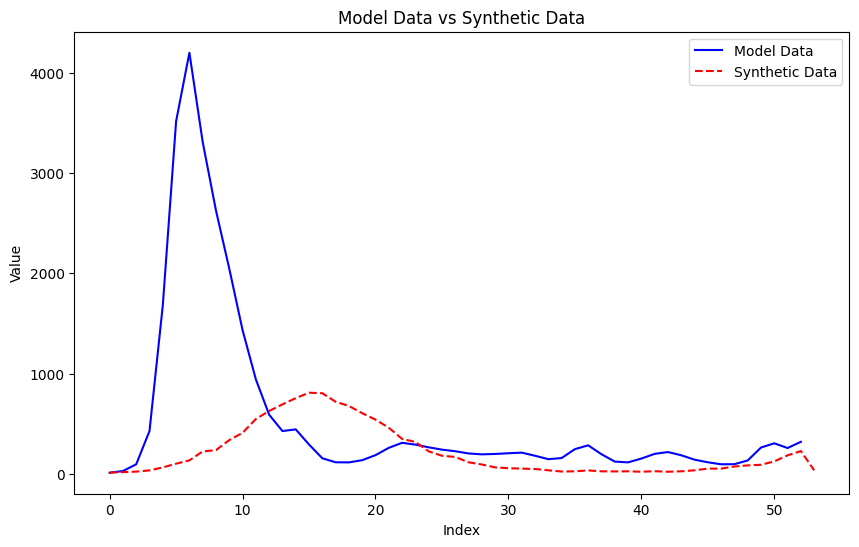

In [16]:
import matplotlib.pyplot as plt
import numpy as np


# Plot both datasets
plt.figure(figsize=(10, 6))
plt.plot(model_data, label="Model Data", color="blue")
plt.plot(synthetic_data, label="Synthetic Data", color="red", linestyle="--")

# Adding labels and title
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Model Data vs Synthetic Data")
plt.legend()

# Display the plot
plt.show()
